<a href="https://colab.research.google.com/github/solobala/FEML23/blob/master/1_decision_trees_%D0%9F%D0%BE%D0%BD%D0%BE%D0%BC%D0%B0%D1%80%D0%B5%D0%B2%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Деревья решений. Классификация

### План

* критерий информативности
* визуализация разделяющих поверхностей решения и визуализация самого дерева
* оценка важности фичей
* ужасы переобучения

## 1. Критерий информативности

как мы разобрали, построение дерева зависит от следующих факторов:
* вид правила разбиения
* критерий информативности
* критерий останова
* метод стрижки
* проблема пропусков

пройдёмся по критериям информативности

In [ ]:
import numpy as np
from collections import Counter

*Нам понадобятся две библиотеки: numpy вы знаете, а объект класса Counter в заданном списке просто подсчитывает количество вхождений каждого элемента и возвращает результат в виде словаря. Пример:*

In [ ]:
Counter([9,9,9,7,7])

Counter({9: 3, 7: 2})

*Для численного измерения улучшения разбиений на каждом этапе мы вводим некоторый *критерий информативности*, который будет оценивать разнообразие объектов в выборке: чем больше разных классов в выборке, тем больше значение H(R). Чем меньше взвешенное значение критерия после разбиения - тем лучше*

Ниже представлена функция для расчёта энтропийного критерия качества:

$H(R) = -\sum_{k=1}^{K}p_klogp_k$

**Задание.** Дополните функцию расчёта энтропийного критерия множества

$Н(R) = -\sum_{k=1}^{K}p_klog(p_k)$

In [ ]:
def HEntropy(l):
    length = len(l)
    cnt = Counter(l)

    ent = 0
    for cl in cnt.values():
        p = cl / length
        l2 = np.log2(p)
        it = -p * l2
        ent += it

    return ent

**Задание.** По аналогии с *энтропийным критерием* заполните функции *критерия Джини*

$Н(R) = \sum_{k=1}^{K}p_k(1-p_k)$

In [ ]:
def HGini(l):
    length = len(l)
    cnt = Counter(l)

    gini = 0
    for cl in cnt.values():
        p_1 = cl / length
        p_2 = (1 - p_1)
        it = p_1 * p_2
        gini += it

    return gini

*Information Gain (IG)* - функционал качества, отвечающий на вопрос, а сколько энтропии мы погасили при определённом разбиении? На каждом шаге разбиения при построении дерева максимизируется IG. Формула для вычисления при критерии информативности H:

$IG(R) = H(R) - \frac{|R_l|}{|R|}H(R_l) - \frac{|R_r|}{|R|}H(R_r)$

**Задание.** Заполните функцию для вычисления функционала качества

In [ ]:
def IG(H, l, i):
    left_l = l[:i]
    right_l = l[i:]
    return H(l) - (len(left_l) / len(l)) * H(left_l) - (len(right_l) / len(l)) * H(right_l)

Тут функция для визуализации работы произвольного критерия качества на выборке

In [ ]:
def test_H(H, l):
    print("{:5} {:3}   {:4} {:4} {:4}".format("#","l","IG","Hl","Hr"))
    print("-" * 24)
    i_max, IG_max=0, 0

    for i in range(0, len(l)):
        print(f"{i:2}. {l[i]:3}   {IG(H, l, i):.2f} {H(l[:i]):.2f} {H(l[i:]):.2f}")

        if IG_max < IG(H, l, i):
            i_max, IG_max = i, IG(H, l, i)

    print(f'Деление после элемента:{i_max-1}')

Определим как-нибудь выборку и посмотрим, какое разбиение предложат критерии информативности. Замечу, что элементы здесь будут выводиться начиная со второго, а значения функций рассчитаны для разбиения *перед* элементом строки

In [ ]:
l = [1]*5 + [2]*3
print(l)

[1, 1, 1, 1, 1, 2, 2, 2]


In [ ]:
test_H(HEntropy, l)

#     l     IG   Hl   Hr  
------------------------
 0.   1   0.00 0.00 0.95
 1.   1   0.09 0.00 0.99
 2.   1   0.20 0.00 1.00
 3.   1   0.35 0.00 0.97
 4.   1   0.55 0.00 0.81
 5.   2   0.95 0.00 0.00
 6.   2   0.47 0.65 0.00
 7.   2   0.20 0.86 0.00
Деление после элемента:4


In [ ]:
test_H(HGini, l)

#     l     IG   Hl   Hr  
------------------------
 0.   1   0.00 0.00 0.47
 1.   1   0.04 0.00 0.49
 2.   1   0.09 0.00 0.50
 3.   1   0.17 0.00 0.48
 4.   1   0.28 0.00 0.38
 5.   2   0.47 0.00 0.00
 6.   2   0.26 0.28 0.00
 7.   2   0.11 0.41 0.00
Деление после элемента:4


## 2. Визуализация принятия решений классификатором sklearn

#### 1. Используем данные о цветках ириса из занятия

In [ ]:
from sklearn.datasets import load_iris
import pandas as pd

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

In [ ]:
iris = load_iris()

In [ ]:
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = pd.DataFrame(iris.target, columns=['species'])
df = pd.concat([X,y], axis=1)

In [ ]:
print(df.shape)
df.head()

(150, 5)


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


Выведем попарное распределение фичей датасета с раскраской по виду цветка

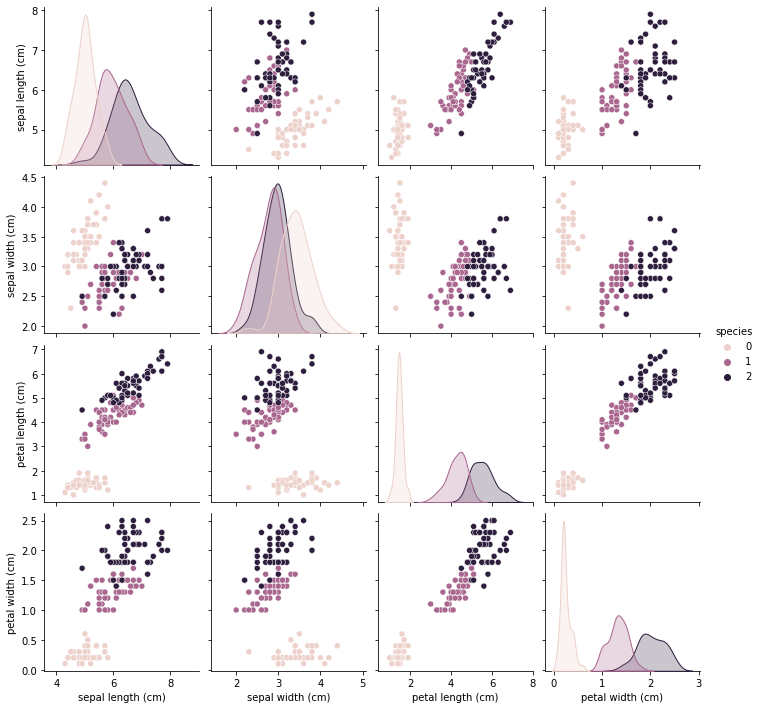

In [ ]:
sns.pairplot(df, hue='species', diag_kind="kde");

Визуально кажется, что ширина листка (petal width) может самостоятельно отделить два класса друг от друга идеально. Для других двух классов понадобится еще хотя бы ещё одна фича.

Возьмём две фичи для возможности изобразить это в 2D:
длину и ширину листка

In [ ]:
Xcut = X[X.columns[2:4]]
Xcut.head()

,petal length (cm),petal width (cm)
0,1.4,0.2
1,1.4,0.2
2,1.3,0.2
3,1.5,0.2
4,1.4,0.2


#### 2. Используем классификатор

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
clf = DecisionTreeClassifier(max_depth=2)

In [ ]:
clf.fit(Xcut, y)

DecisionTreeClassifier(max_depth=2)

In [ ]:
clf.predict(Xcut)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2,
       2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [ ]:
df.species.unique()

array([0, 1, 2])

In [ ]:
clf.predict_proba(Xcut)[:10]

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

Визуализируем границу принятия решений. Для удобства все упаковано в функцию **test_clf**, в неё передаётся созданный классификатор и при установленном fit_clf=True обучается внутри, а затем отрисовывает границу. Таким образом можно экспериментировать с параметрами классификатора

In [ ]:
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 0.5, data[:, 0].max() + 0.5
    y_min, y_max = data[:, 1].min() - 0.5, data[:, 1].max() + 0.5
    return np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

In [ ]:
def test_clf(clf, X, y, cy=0, fit_clf=False):
    xx,yy = get_grid(X.values)

    if fit_clf:
        clf.fit(X, y)

    predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    plt.figure(figsize=(8, 8))
    plt.pcolormesh(xx, yy, predicted, cmap='Pastel1')
    plt.scatter(X.values[:, 0], X.values[:, 1], s=50, cmap='tab10',c=cy)
    plt.xlabel(X.columns[0])
    plt.ylabel(X.columns[1])

    if fit_clf:
        return clf

*попробуйте при разной глубине*

In [ ]:
dt = DecisionTreeClassifier(max_depth=5, random_state=10)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  "X does not have valid feature names, but"


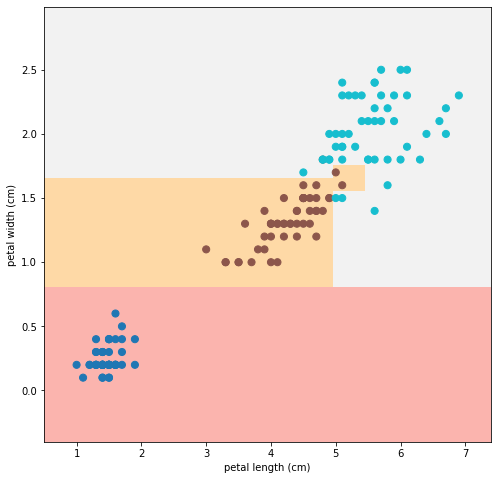

In [ ]:
clf = test_clf(dt, Xcut, y, cy=y['species'].tolist(), fit_clf=True)

обратите внимание, один блок занимает то позицию снизу, то слева: данных недостаточно для принятия однозначного решения и экстраполяция идёт произвольно

#### 3. Визуализируем само дерево

Возможно, самое замечательное свойство одиночных деревьев - возможность визуализировать их алгоритм работы и затем объяснить его хоть человеку, хоть машине

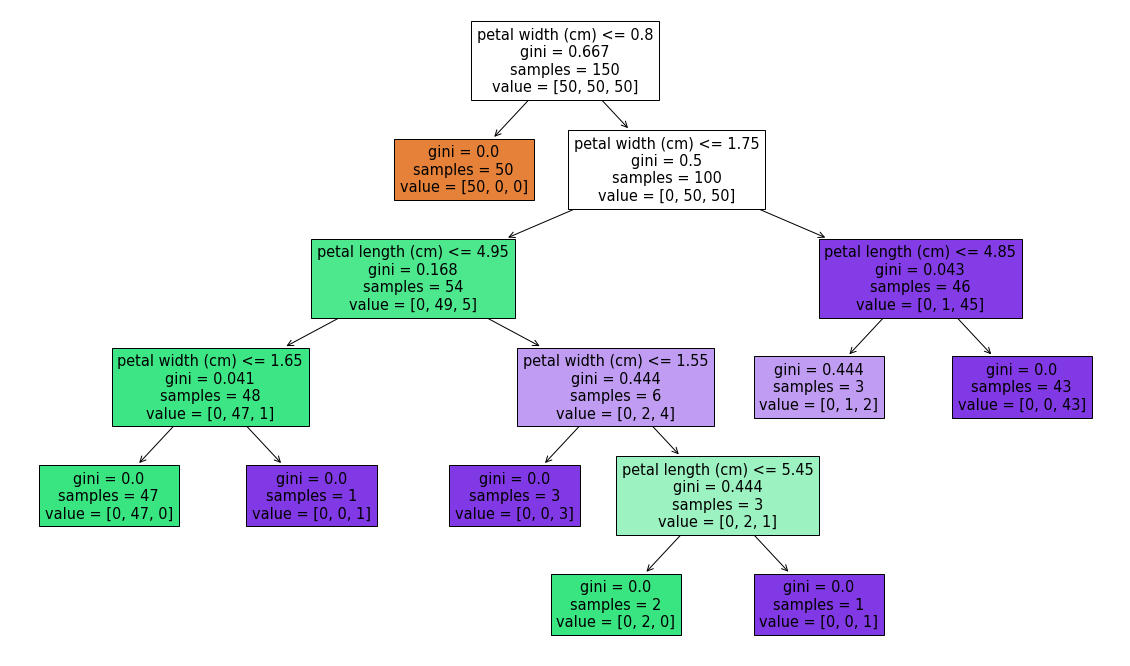

In [ ]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 12))
plot_tree(dt, feature_names=Xcut.columns, filled=True);

-----

## 3. DecisionTreeRegressor

In [ ]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

In [ ]:
# Create a random dataset
np.random.seed(1)

X = np.sort(5 * np.random.rand(80, 1), axis=0)
y = np.sin(X).ravel()

y[::5] += 3 * (0.5 - np.random.rand(16))

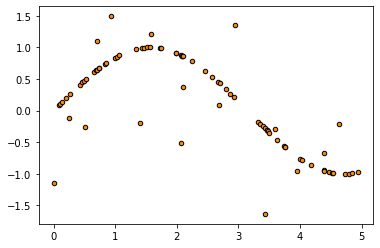

In [ ]:
plt.scatter(X, y, s=20, edgecolor="black", c="darkorange", label="data");

In [ ]:
# Fit regression model
list_depth = [1,2,3,4,5,7]

dt_regs = {}
for i in list_depth:
    dt_regs[f'depth={i}'] = DecisionTreeRegressor(max_depth=i, random_state=10).fit(X, y)

dt_regs['depth=inf'] = DecisionTreeRegressor(random_state=10).fit(X, y)
dt_regs['reg'] = DecisionTreeRegressor(min_samples_leaf=3, random_state=10).fit(X, y)

In [ ]:
# Predict
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]

pred_list = {}
for key, cur_dt_reg in dt_regs.items():
      pred_list[key] = cur_dt_reg.predict(X_test)

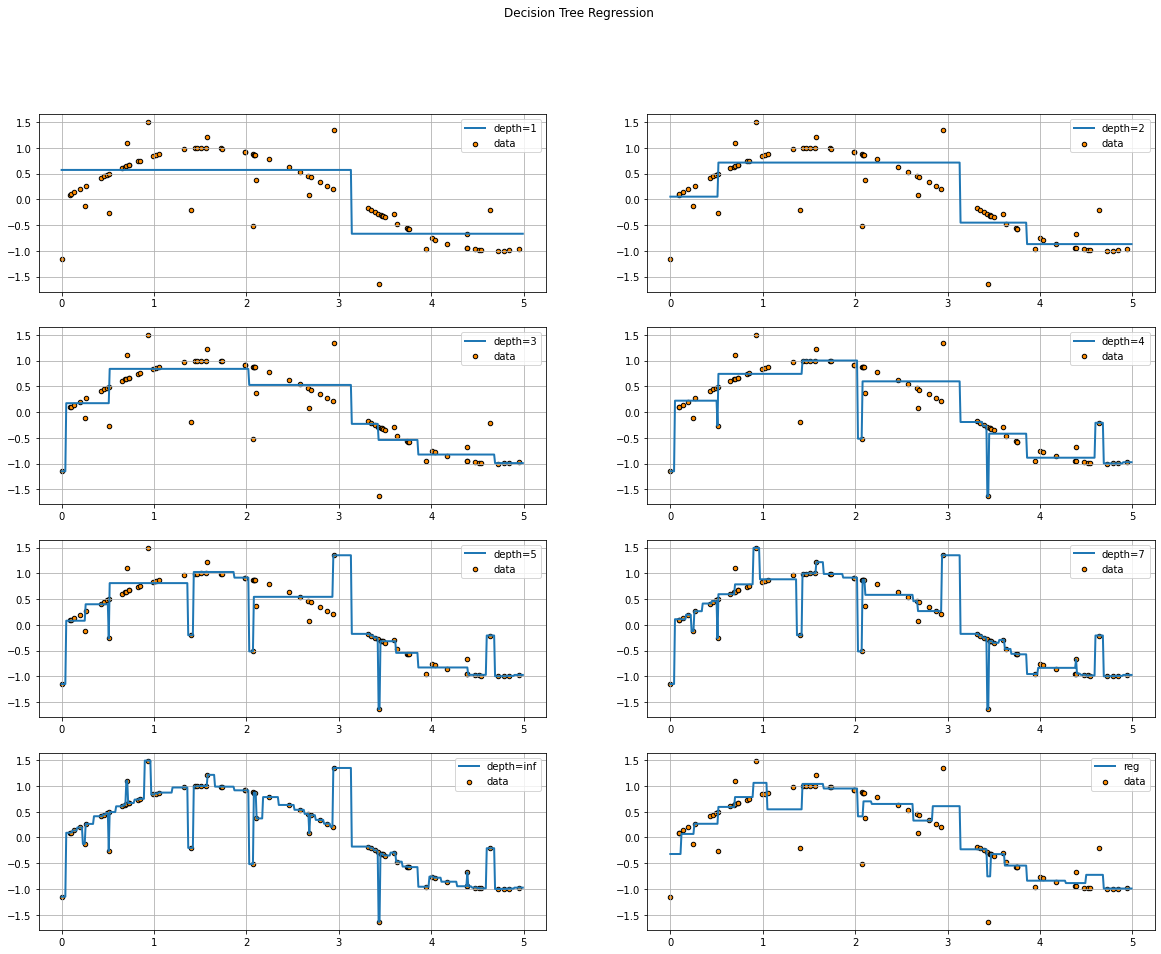

In [ ]:
# Plot the results

fig, axa = plt.subplots(4,2, figsize=(20,15))

for i, (key , cur_pred) in enumerate(pred_list.items()):
    ax = axa[i//2, i%2]
    ax.scatter(X, y, s=20, edgecolor="black", c="darkorange", label="data")
    ax.plot(X_test, cur_pred, label=f"{key}", linewidth=2)
    ax.grid()
    ax.legend()

fig.suptitle("Decision Tree Regression")
plt.show()

## 4. Оценка важности фичей

важность зависит от конкретного прогона классификатора, это не объективный показатель, но дающий представление

In [ ]:
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = pd.DataFrame(iris.target, columns=['species'])

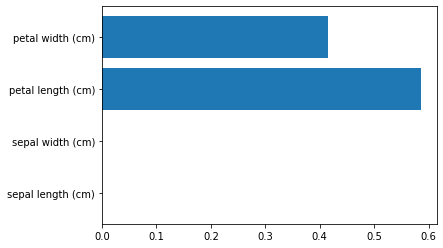

In [ ]:
clf = DecisionTreeClassifier(max_depth=3)
clf.fit(X, y)

plt.barh(np.arange(len(clf.feature_importances_)), clf.feature_importances_)
plt.yticks(np.arange(len(X.columns)), X.columns)
plt.show()

## **Дополнительные материалы**
1. Дерево решений для задачи регресии https://youtu.be/0mMeaC3gjNI
2. Дерево решений для задачи классификации https://youtu.be/j8L07nuns2Y
3. Критерии останова дерева решений https://youtu.be/aWEdaXAZ01M